# Visualizing the Results

Taking the log of the voting power data is best for visualization, communicates the most variation.  

In [119]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona

import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib

import altair as alt
from vega_datasets import data

In [120]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [121]:
vp_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 
    'output', 'voting_power.csv'), dtype={'geoid': 'str'})
vp_df.head()

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
0,01,AL,president,2016,27.725147,-27.725147,0.418216,0.015084
1,02,AK,president,2016,14.730641,-14.730641,0.139405,0.009464
2,04,AZ,president,2016,3.545595,-3.545595,0.511152,0.144165
3,05,AR,president,2016,26.920978,-26.920978,0.278810,0.010357
4,06,CA,president,2016,30.109293,30.109293,2.555762,0.084883


In [122]:
# https://www.reddit.com/r/gis/comments/775imb/accessing_a_gdb_without_esri_arcgis/
# create a list of layers with in a file geodatabase 
db_path = os.path.join(os.getcwd(), 'data','shapefiles',
    'geodatabase','2018','tlgdb_2018_a_us_legislative.gdb')
layerlist = fiona.listlayers(db_path)
print(layerlist)

['Congressional_Districts_116th', 'State_Legislative_Districts_Upper', 'State_Legislative_Districts_Lower', 'Voting_Districts']


In [123]:
state_path = os.path.join(os.getcwd(), 'data', 'shapefiles',
    'state', 'tl_2018_us_state', 'tl_2018_us_state.shp')
stgeo_df = gpd.read_file(state_path)
stgeo_df = stgeo_df.to_crs({'init': 'EPSG:5070'})

#https://altair-viz.github.io/gallery/choropleth_repeat.html
states = alt.topo_feature(data.us_10m.url, 'states')  #data.us_10m.url

# Plotting Functions

In [147]:
def altair_states(data_df, states, w, h, titles):
    mp1 = alt.Chart(states).mark_geoshape(
        stroke='gray',
        strokeWidth=0.25
    ).encode(
        alt.Color('dem_margin', type='quantitative', 
            scale=alt.Scale(scheme='redblue', domain=[-25, 0, 25]),  #redblue spectral
            legend=alt.Legend(title=titles[0])
        ) 
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(data_df, 'geoid', ['dem_margin'])
    ).properties(
        width=w,
        height=h
    ).project(
        type='albersUsa'
    )

    mp2 = alt.Chart(states).mark_geoshape(
        stroke='gray',
        strokeWidth=0.25
    ).encode(
        alt.Color('voting_power', type='quantitative', 
            scale=alt.Scale(scheme="reds"),  # oranges "viridis"
            legend=alt.Legend(title=titles[1])
        )
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(data_df, 'geoid', ['voting_power']) 
    ).properties(
        width=w,
        height=h
    ).project(
        type='albersUsa'
    )
    return mp1, mp2

def add_colorbar(fig, data_df, column, cmap, label):
    # https://stackoverflow.com/questions/53158096
    vmin = data_df[column].min()
    vmax = data_df[column].max()
    cax = fig.add_axes([0.7, 0.87, 0.08, 0.02])  # [left, bottom, width, height] 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    #ticks = [int(vmin), int(vmax)]
    cbr = fig.colorbar(sm, cax=cax, label=label, orientation='horizontal') #ticks=ticks
    return fig

def matplotlib_districts(district_df, state_outlines_df):
    temp_df = district_df.copy()
    
    # Construct colormap using midpoint:
    cmap = clr.LinearSegmentedColormap.from_list('red_blue', 
        [(0, '#EF3B2C'), (0.5, '#EEEEEE'), (1,'#08519C')], N=256)
    
    exclude = ['02', '15', '60', '66', '69', '72', '78']
    temp_df = temp_df[~(temp_df['GEOID'].str[0:2].isin(exclude))]
    state_outlines_df = state_outlines_df[~(state_outlines_df['GEOID'] \
        .str[0:2].isin(exclude))]
    
    # Clip to show more middle range resolution
    temp_df['dem_margin'] = temp_df['dem_margin'].clip(lower=-25.0, upper=25.0)
    
    fig1, ax1 = plt.subplots(figsize=(20,10))
    temp_df.plot(ax=ax1, column='dem_margin', cmap=cmap, k=3, linewidth=0.1)
    state_outlines_df.plot(ax=ax1, edgecolor='black', alpha=0.1, facecolor='white')
    fig1 = add_colorbar(fig=fig1, data_df=temp_df, column='dem_margin', 
        label='dem_margin', cmap=cmap)
    ax1.axis('off')
    
    fig2, ax2 = plt.subplots(figsize=(20,10))
    temp_df.plot(ax=ax2, column='voting_power', cmap='Reds')
    state_outlines_df.plot(ax=ax2, edgecolor='black', alpha=0.1, facecolor='white')
    fig2 = add_colorbar(fig=fig2, data_df=temp_df, column='voting_power', 
        label='log(voting_power)', cmap='Reds')
    ax2.axis('off')
    
    return ax1, ax2

# Note: You an pass legend keywords to the plot function:
# http://geopandas.org/reference.html#geopandas.GeoDataFrame.plot
# But numeric data uses a colormap, not a legend:
# https://github.com/geopandas/geopandas/issues/694
# Note however that in your case above, the legend_kwds won't necessarily have effect. 
# If your data is numeric, then you will get a colorbar and not a legend, and the 
# legend_kwds will be ignored.

# President

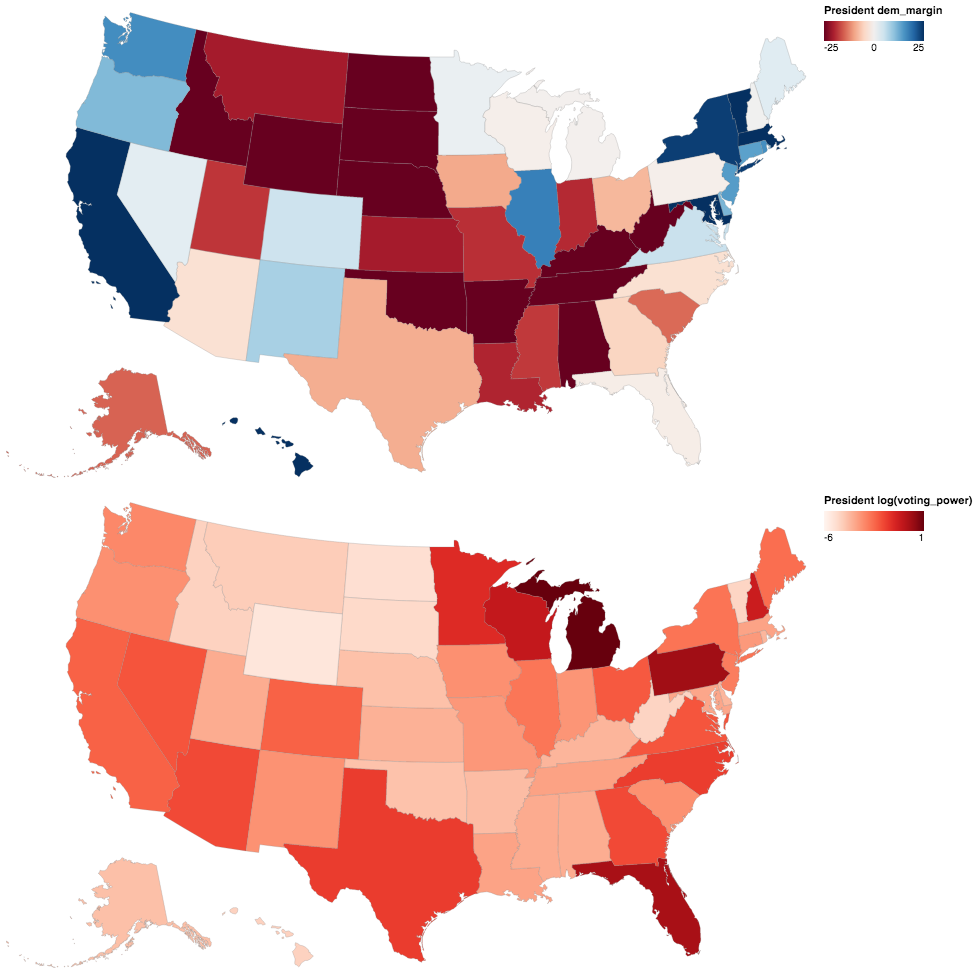

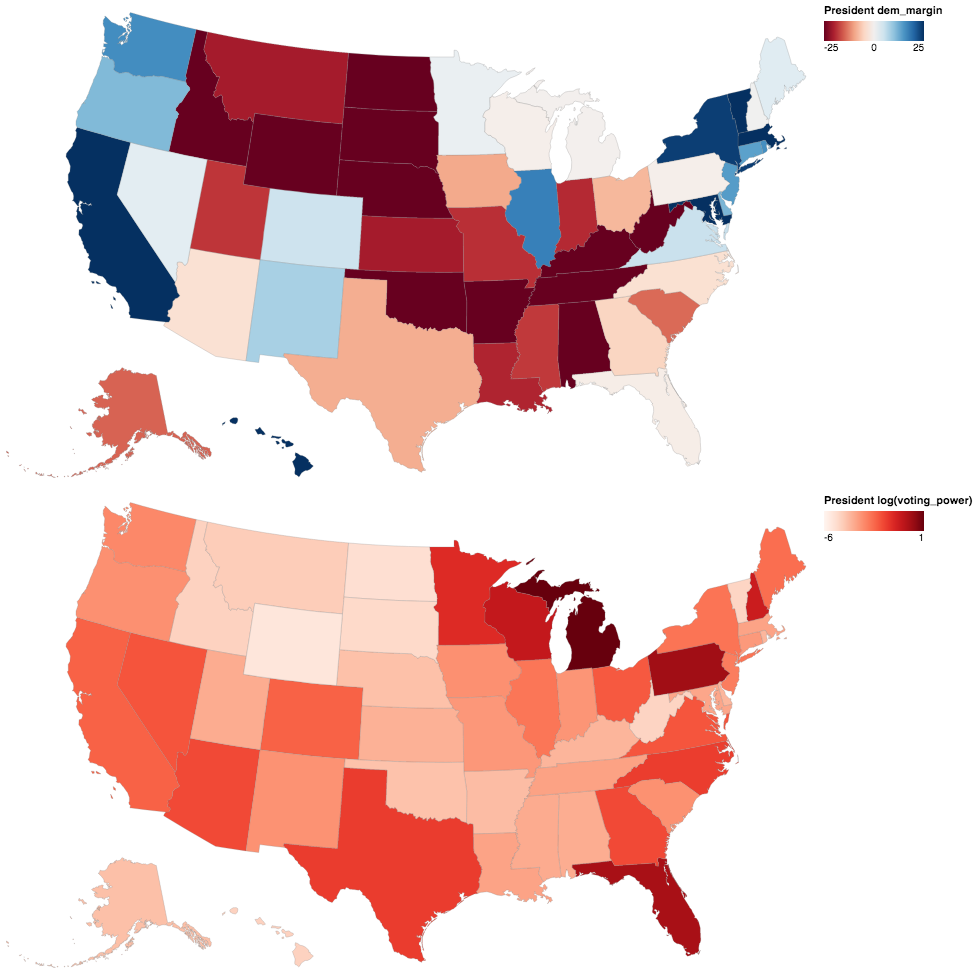

In [125]:
data_df = vp_df[vp_df.office == 'president'].copy()
data_df['geoid'] = data_df.geoid.astype(int)
data_df['voting_power'] = np.log(data_df.voting_power)
variable_list = ['dem_margin', 'voting_power']
w = 800
h = (3/5)*w

mp1, mp2 = altair_states(data_df, states, w, h, 
    titles=['President dem_margin', 'President log(voting_power)'])

display(alt.vconcat(mp1, mp2).resolve_scale(
    color='independent'
).configure_view(
    strokeWidth=0
))

# US Senate

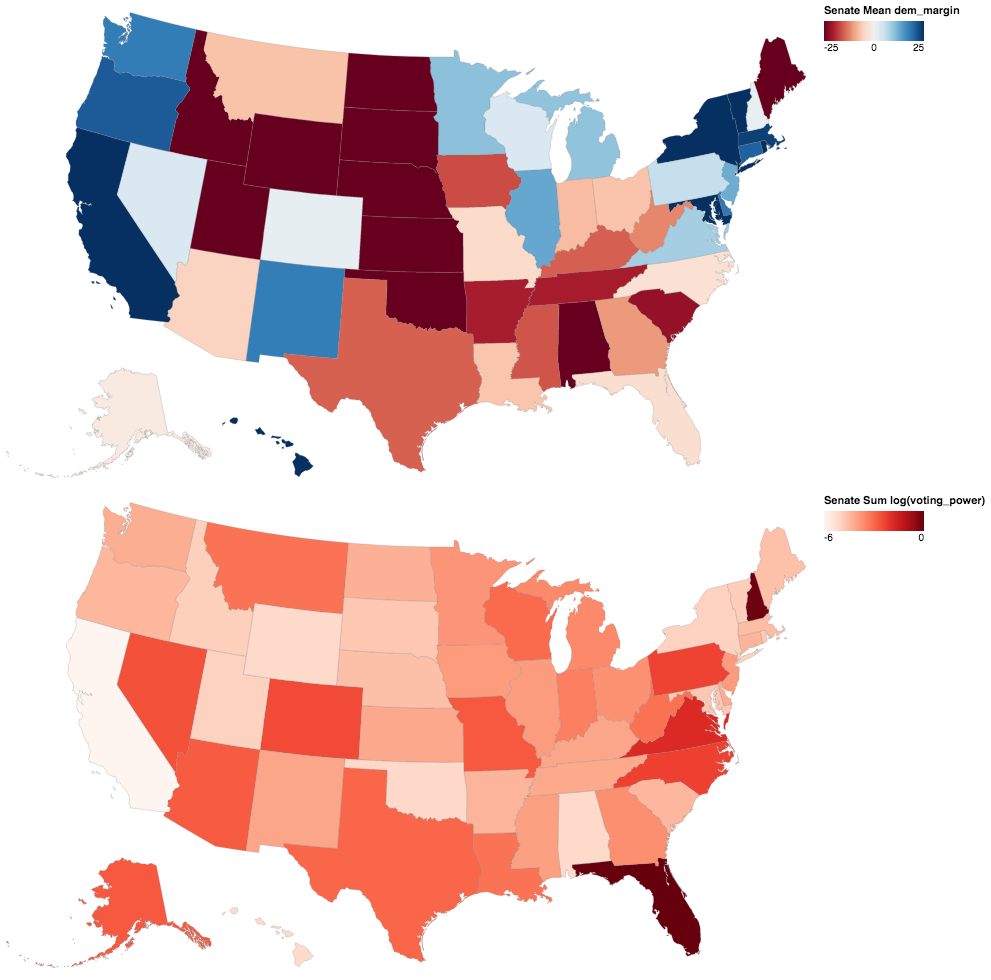

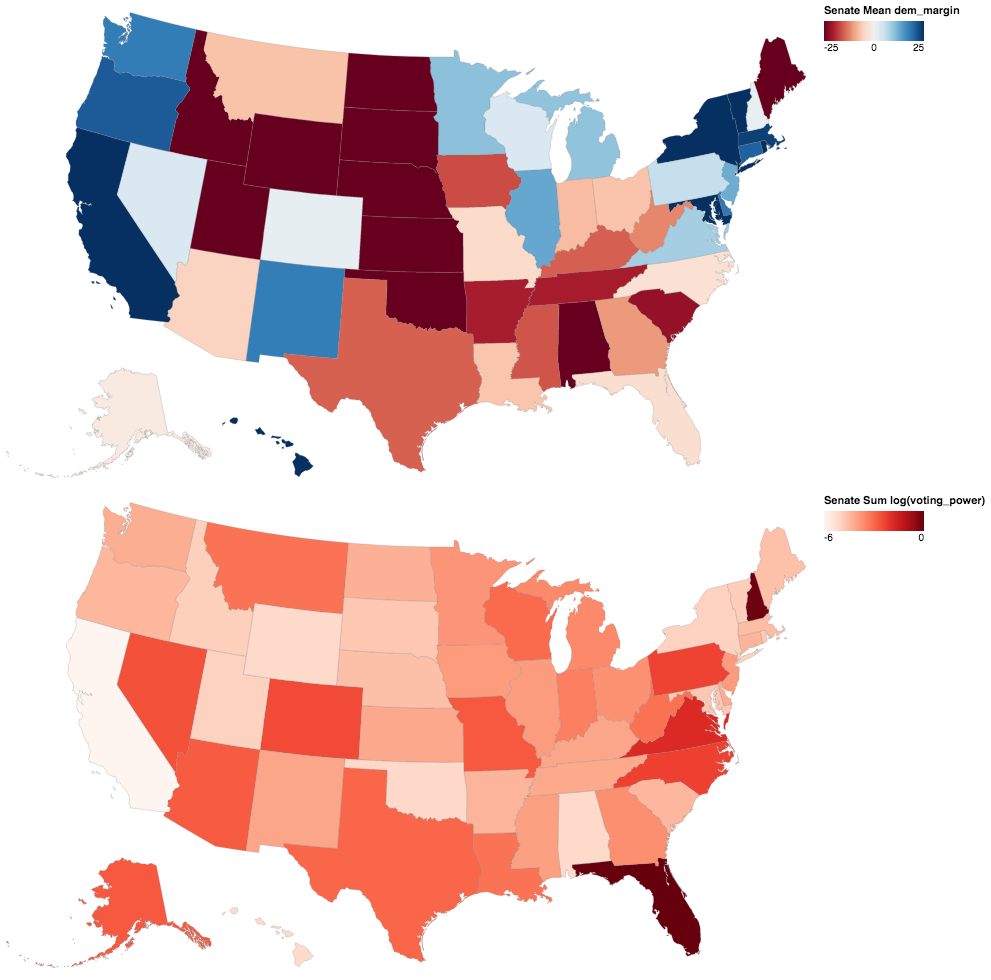

In [126]:
data_df = vp_df[vp_df.office == 'ussenate'].copy()
# Calculate mean margin, sum the voting power
data_df = data_df.groupby(by='geoid') \
    .agg({'dem_margin':'mean', 'voting_power':'sum'})
data_df.reset_index(inplace=True, drop=False)
data_df.rename(columns={'index':'geoid'}, inplace=True)
data_df['geoid'] = data_df.geoid.astype(int)
data_df['dem_margin'] = data_df.dem_margin.fillna(0)
data_df['voting_power'] = np.log(data_df.voting_power)

mp1, mp2 = altair_states(data_df, states, w, h, 
    titles=['Senate Mean dem_margin', 'Senate Sum log(voting_power)'])

display(alt.vconcat(mp1, mp2).resolve_scale(
    color='independent'
).configure_view(
    strokeWidth=0
))

# US House

In [151]:
temp_df = gpd.read_file(db_path, driver="OpenFileGDB",layer='Congressional_Districts_116th')
data_df = vp_df[vp_df.office == 'ushouse'].copy()
data_df['dem_margin'] = data_df.dem_margin.fillna(0)
data_df['voting_power'] = np.log(data_df.voting_power)
#Clip to show more middle range resolution
#Clipped in plotting function now, -20, 20
#data_df['dem_margin'] = data_df['dem_margin'].clip(lower=-50.0, upper=50.0)
temp_df = temp_df.merge(data_df, left_on='GEOID', right_on='geoid')

# Set Coordinate System
# http://spatialreference.org/ref/?search=albers&srtext=Search
# https://gis.stackexchange.com/questions/128190: EPSG:5070
temp_df = temp_df.to_crs({'init': 'EPSG:5070'})

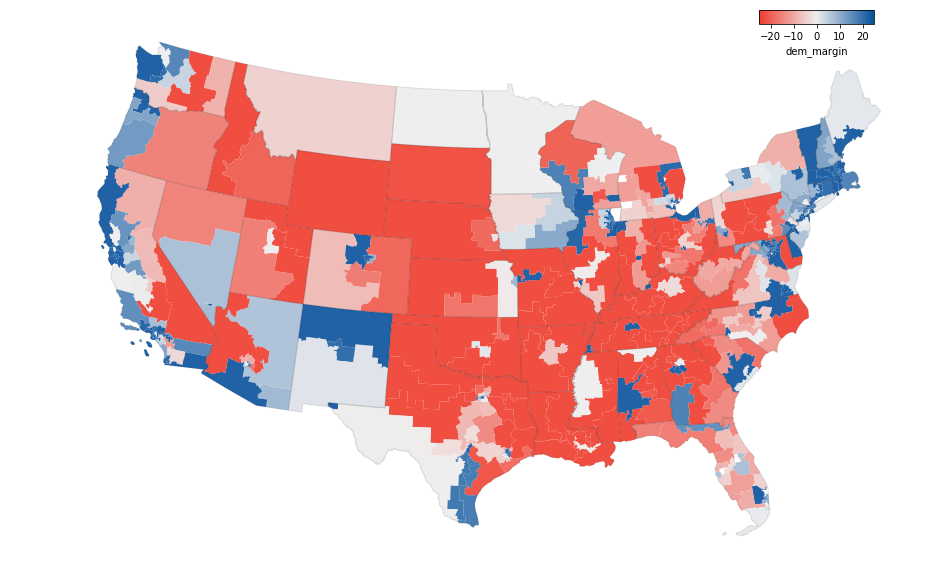

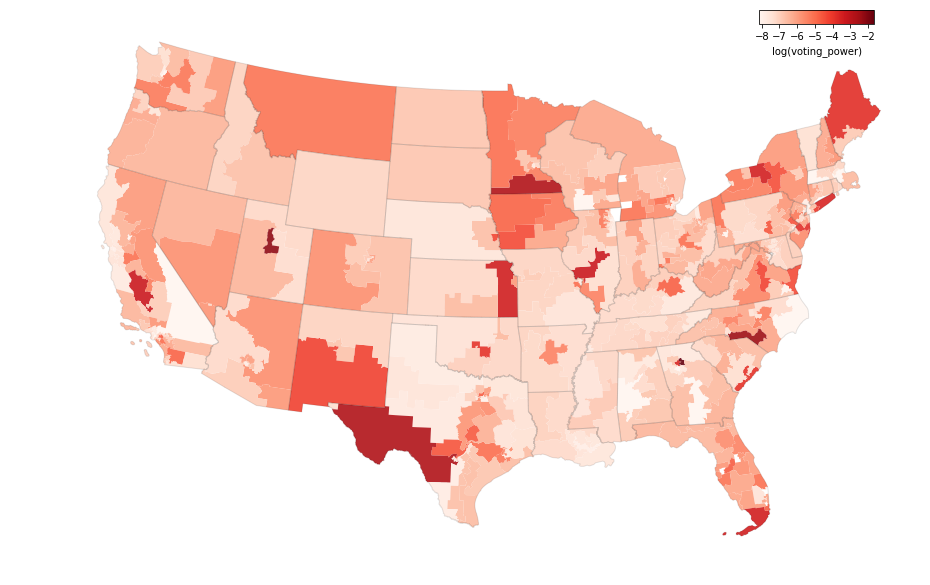

In [152]:
ax1, ax2 = matplotlib_districts(temp_df, stgeo_df)
display(ax1, ax2)

In [150]:
data_df.sort_values(by='voting_power', ascending=False).head(10)

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
467,1307,GA,ushouse,2018,0.149408,-0.149408,0.028736,-1.648540
540,4904,UT,ushouse,2018,0.257733,0.257733,0.028736,-2.193786
477,3709,NC,ushouse,2018,0.320108,-0.320108,0.028736,-2.410521
470,4823,TX,ushouse,2018,0.440808,-0.440808,0.028736,-2.730470
234,2701,MN,ushouse,2018,0.450866,0.000000,0.028736,-2.753032
187,0621,CA,ushouse,2018,0.758696,0.758696,0.028736,-3.273463
249,1713,IL,ushouse,2018,0.759463,-0.759463,0.028736,-3.274474
411,2002,KS,ushouse,2018,0.845902,-0.845902,0.028736,-3.382265
530,1226,FL,ushouse,2018,0.874615,0.874615,0.028736,-3.415646
402,3624,NY,ushouse,2018,0.907566,0.907566,0.028736,-3.452628


# Governors

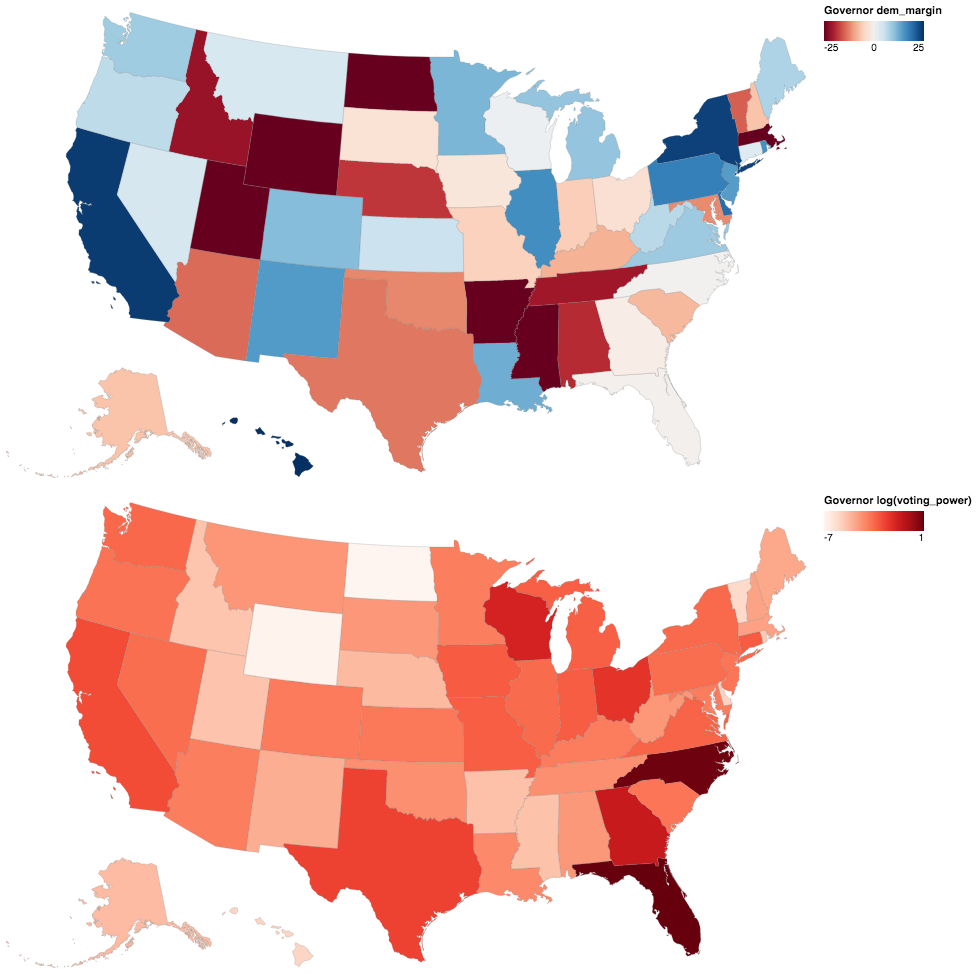

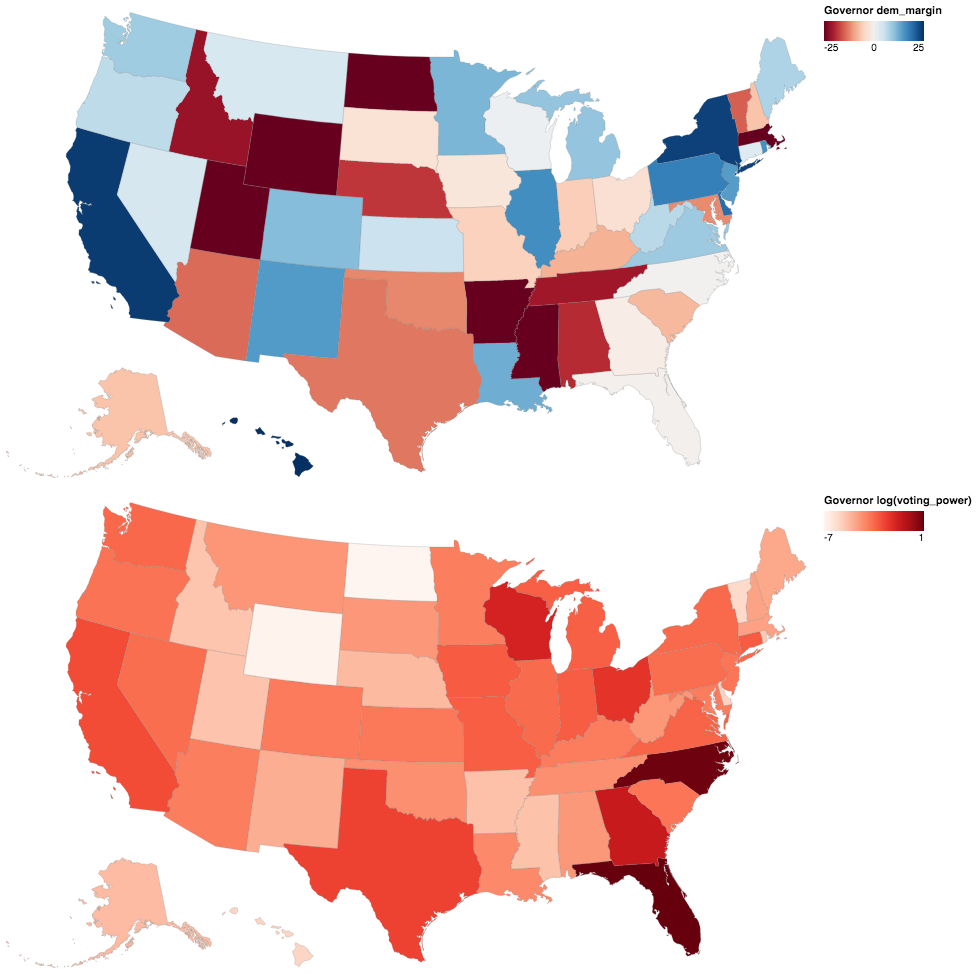

In [130]:
#https://altair-viz.github.io/gallery/choropleth_repeat.html
states = alt.topo_feature(data.us_10m.url, 'states')
data_df = vp_df[vp_df.office == 'governor'].copy()
data_df['geoid'] = data_df.geoid.astype(int)
data_df['dem_margin'] = data_df.dem_margin.fillna(0)
data_df['voting_power'] = np.log(data_df.voting_power)

mp1, mp2 = altair_states(data_df, states, w, h, 
    titles=['Governor dem_margin', 'Governor log(voting_power)'])

display(alt.vconcat(mp1, mp2).resolve_scale(
    color='independent'
).configure_view(
    strokeWidth=0
))

# State Senates

In [153]:
temp_df = gpd.read_file(db_path, driver="OpenFileGDB",layer='State_Legislative_Districts_Upper')
data_df = vp_df[vp_df.office == 'statesenate'].copy()
data_df['voting_power'] = np.log(data_df.voting_power)
# Clip to show middle ranges better
#Clipped in plotting function now, -20, 20
#data_df['dem_margin'] = data_df['dem_margin'].clip(lower=-50.0, upper=50.0)
temp_df = temp_df.merge(data_df, how='left', left_on='GEOID', right_on='geoid')
temp_df['dem_margin'] = temp_df.dem_margin.fillna(0)
temp_df['voting_power'] = temp_df.voting_power.fillna(temp_df.voting_power.min())

# Set Coordinate System
# http://spatialreference.org/ref/?search=albers&srtext=Search
# https://gis.stackexchange.com/questions/128190: EPSG:5070
temp_df = temp_df.to_crs({'init': 'EPSG:5070'})  # EPSG:3857  #Albers: 'EPSG:3311'

# Nebraska is missing from both datasets.
# data_df[data_df.state_abbr == 'NE'] 
# And it's missing in the source as well:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DRSACA
# https://scholarsportal.github.io/Dataverse-Data-Explorer/
# ?fileId=3243688&siteUrl=https://dataverse.harvard.edu
# But Nebraska is in version that's not organized by elections:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/3WZFK9
# https://scholarsportal.github.io/Dataverse-Data-Explorer/?fileId=3231005&siteUrl
# =https://dataverse.harvard.edu#?selected=@_id%3Dv19100323%26type%3Drow&view=chart
# I think Nebraska is missing because it's impossible to categorize by Rep/Dem/Other
# because they technically have non-partisan elections.  

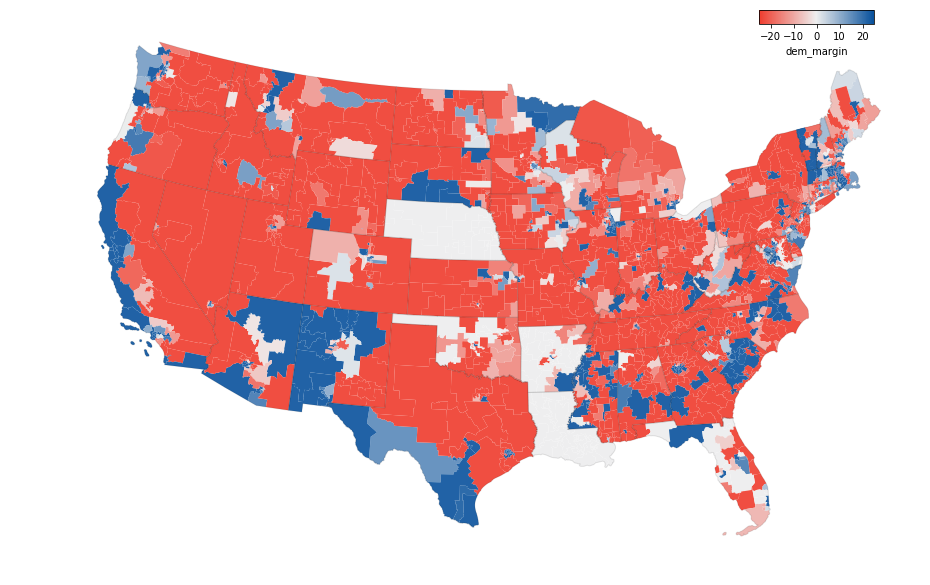

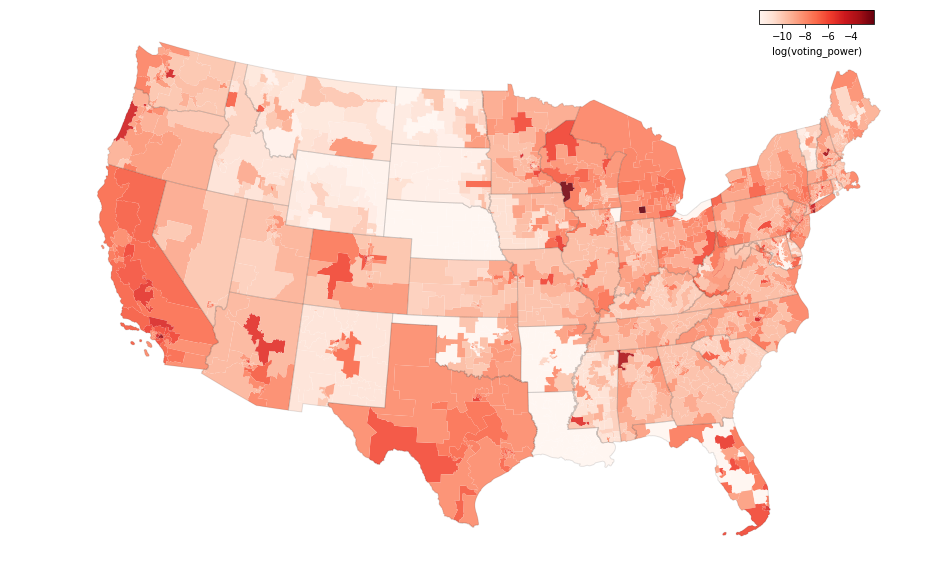

In [154]:
ax1, ax2 = matplotlib_districts(temp_df, stgeo_df)
display(ax1, ax2)

# State Houses

In [155]:
temp_df = gpd.read_file(db_path, driver="OpenFileGDB",layer='State_Legislative_Districts_Lower')
data_df = vp_df[vp_df.office == 'statehouse'].copy()
# data_df['dem_margin'] = data_df.dem_margin.fillna(0)
data_df['voting_power'] = np.log(data_df.voting_power)
# Clip to show middle ranges better
# Clipped in plotting function now, -20, 20
# data_df['dem_margin'] = data_df['dem_margin'].clip(lower=-50.0, upper=50.0)
# Maybe do a merge that preserves all the left shapes, 
# then fill them with 0 for missing? Just to fill out the map
temp_df = temp_df.merge(data_df, how='left', left_on='GEOID', right_on='geoid')
temp_df['dem_margin'] = temp_df.dem_margin.fillna(0)
temp_df['voting_power'] = temp_df.voting_power.fillna(temp_df.voting_power.min())

# Set Coordinate System
# http://spatialreference.org/ref/?search=albers&srtext=Search
# https://gis.stackexchange.com/questions/128190: EPSG:5070
temp_df = temp_df.to_crs({'init': 'EPSG:5070'})

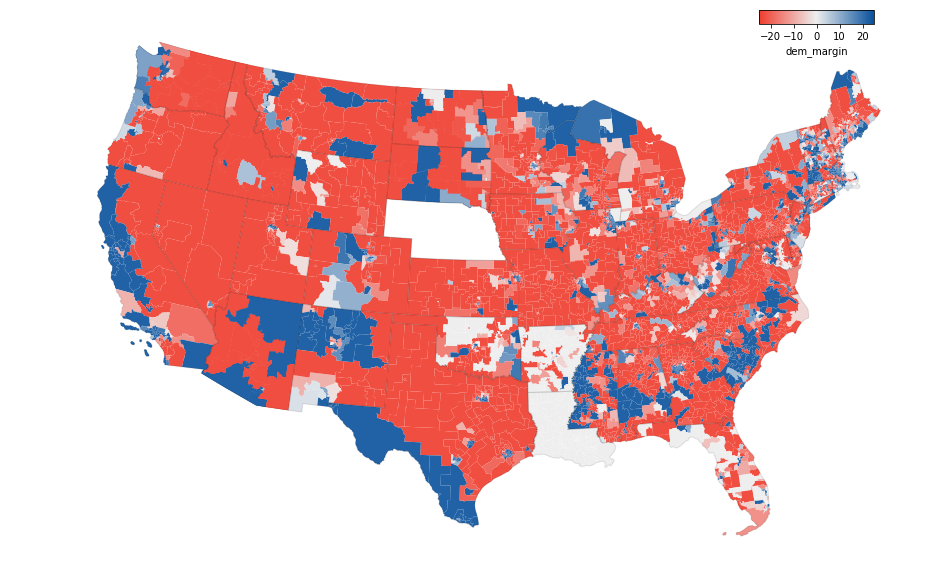

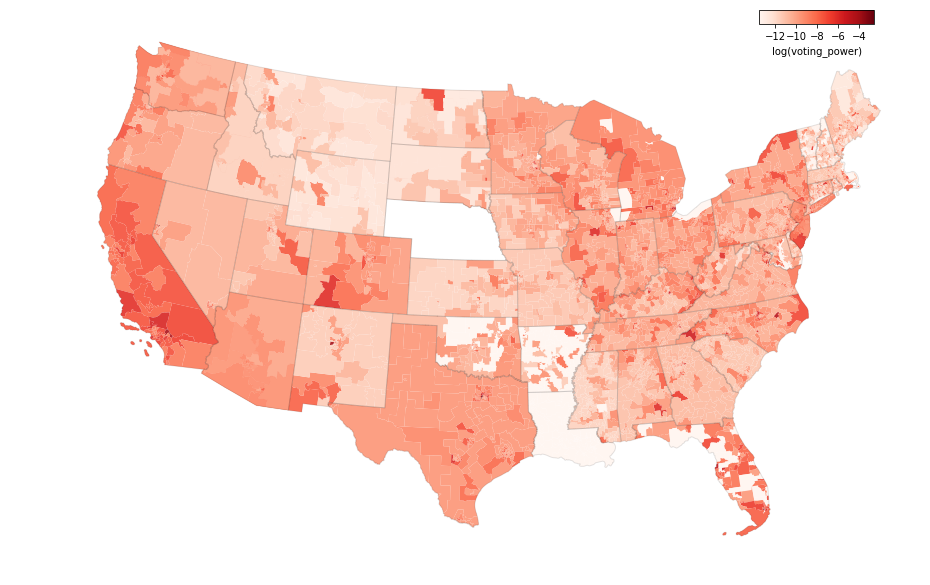

In [156]:
ax1, ax2 = matplotlib_districts(temp_df, stgeo_df)
display(ax1, ax2)